# Testing MPI version for Imaging and deconvolution demonstration

This script makes a fake data set and then deconvolves it. Finally the full and residual visibility are plotted.

In [1]:
from mpi4py import MPI
print(MPI.COMM_WORLD.size)



1


In [2]:

%matplotlib inline



import os
import sys

sys.path.append(os.path.join('..', '..'))

from data_models.parameters import arl_path
results_dir = arl_path('test_results')


from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt

from processing_components.image.iterators import image_raster_iter

from wrappers.serial.visibility.base import create_visibility
from wrappers.serial.skycomponent.operations import create_skycomponent
from wrappers.serial.image.operations import show_image, export_image_to_fits
from wrappers.serial.image.deconvolution import deconvolve_cube, restore_cube
from wrappers.serial.visibility.iterators import vis_timeslice_iter
from wrappers.serial.simulation.testing_support import create_named_configuration, create_test_image
from wrappers.serial.imaging.base import create_image_from_visibility
from workflows.mpi.imaging.imaging_mpi import predict_list_mpi_workflow

from data_models.polarisation import PolarisationFrame

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

backend module://ipykernel.pylab.backend_inline version unknown


In [3]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

Construct LOW core configuration

In [4]:
lowcore = create_named_configuration('LOWBD2', rmax=400.0)

create_configuration_from_file: Maximum radius 400.0 m includes 146 antennas/stations


In [5]:
print(lowcore.xyz)

[[-1697.451395    1786.90252634 -4220.53729446]
 [-1899.245706    1676.22129979 -4000.47217072]
 [-1749.332463    1743.04062531 -4133.32761149]
 [-1980.112908    1741.06827262 -4129.40602467]
 [-1797.563795    1711.65424735 -4070.92274514]
 [-1856.918727    1634.47055507 -3917.46005486]
 [-1854.091115    1685.47915605 -4018.87936901]
 [-1841.933631    1735.45400747 -4118.24330093]
 [-1710.69259     1686.89797425 -4021.70037499]
 [-1998.747741    1692.42716624 -4032.69394958]
 [-1942.270247    1691.73930513 -4031.32629   ]
 [-1654.987395    1654.73474441 -3957.75091061]
 [-1834.982938    1762.89064318 -4172.79497894]
 [-1792.469112    1750.71903274 -4148.59442532]
 [-1882.541622    1709.46473429 -4066.569383  ]
 [-2062.126102    1714.44766716 -4076.47684221]
 [-1789.25535     1675.75003965 -3999.53517422]
 [-1660.667531    1684.05418174 -4016.04612295]
 [-1885.643275    1739.10263634 -4125.49779196]
 [-1776.101351    1727.22766226 -4101.88703409]
 [-1650.104471    1708.87873739 -4065.40

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [6]:
times = numpy.zeros([1])
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))
print(vt)

create_visibility: 10585 rows, 0.001 GB
Visibility:
	Number of visibilities: 10585
	Number of channels: 1
	Frequency: [1.e+08]
	Number of polarisations: 1
	Visibility shape: (10585, 1)
	Polarisation Frame: stokesI
	Phasecentre: <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>
	Configuration: LOWBD2



Plot the synthesized uv coverage.

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


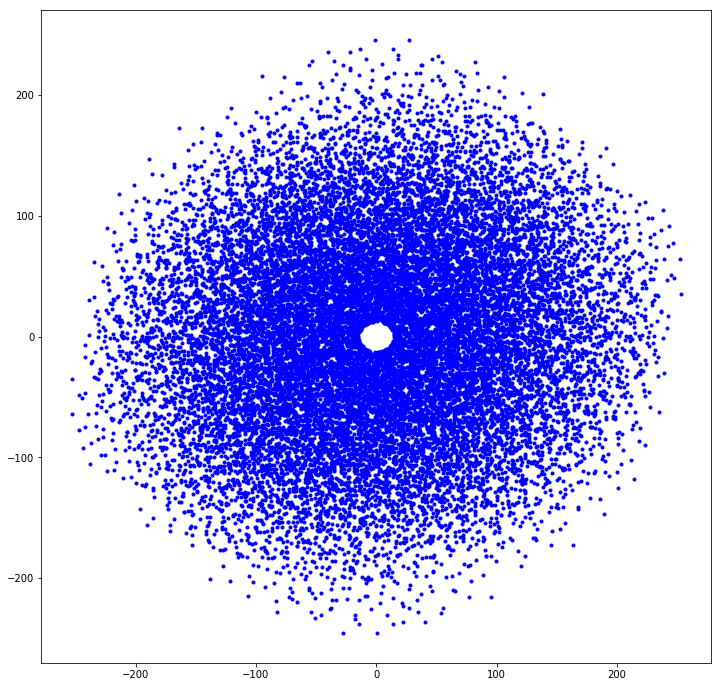

In [7]:
plt.clf()
plt.plot(vt.data['uvw'][:,0], vt.data['uvw'][:,1], '.', color='b')
plt.plot(-vt.data['uvw'][:,0], -vt.data['uvw'][:,1], '.', color='b')
plt.show()

Read the venerable test image, constructing an image

import_image_from_fits: created >f4 image of shape (256, 256), size 0.000 (GB)
import_image_from_fits: Max, min in /Users/montsefarreras/Documents/repo/tmp/algorithm-reference-library/data/models/M31.MOD = 1.006458, 0.000000
replicate_image: replicating shape (256, 256) to (1, 1, 256, 256)
findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=10.0 to STIXGeneral ('/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=10.0 to STIXGeneral ('/Library/Frameworks/Python.framework/V

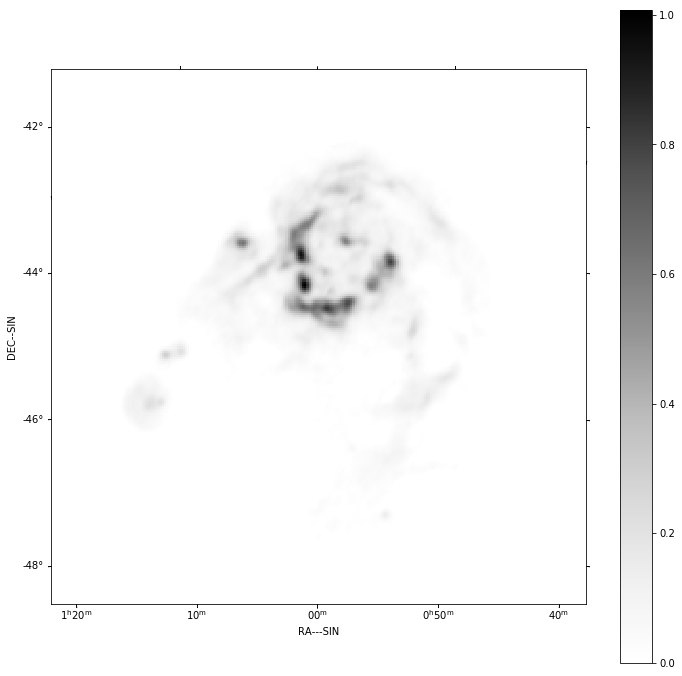

In [8]:
m31image = create_test_image(frequency=frequency, cellsize=0.0005)
nchan, npol, ny, nx = m31image.data.shape
m31image.wcs.wcs.crval[0] = vt.phasecentre.ra.deg
m31image.wcs.wcs.crval[1] = vt.phasecentre.dec.deg
m31image.wcs.wcs.crpix[0] = float(nx // 2)
m31image.wcs.wcs.crpix[1] = float(ny // 2)
print(m31image)
sumwt = numpy.zeros([m31image.nchan, template_model.npol])
fig=show_image(m31image)

In [9]:
vt = predict_list_mpi_workflow([vt], [m31image], context='2d',use_serial_predict=True)
print(vt)


0: In predict_list_mpi_workflow: 1 elements in vis_list
shift_vis_from_image: shifting phasecentre from image phase centre <SkyCoord (ICRS): (ra, dec) in deg
    (14.95950601, -44.97134495)> to visibility phasecentre <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>


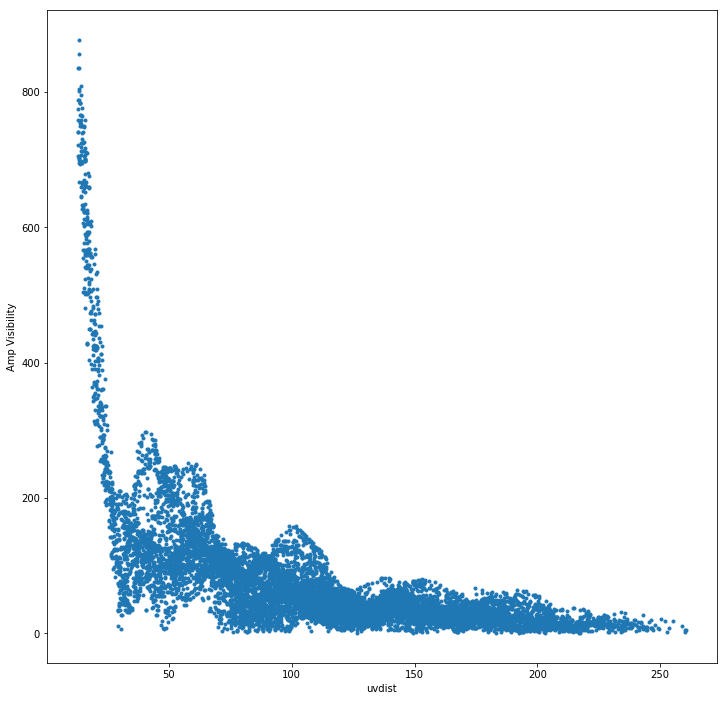

In [10]:
# To check that we got the prediction right, plot the amplitude of the visibility.
vt=vt[0]
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis']), '.')
plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.show()

Make the dirty image and point spread function

In [ ]:
model = create_image_from_visibility(vt, cellsize=0.001, npixel=256)
dirty, sumwt = invert_list_serial_workflow([vt], [model], context='2d')[0]
psf, sumwt = invert_list_serial_workflow([vt], [model], context='2d', dopsf=True)[0]

show_image(dirty)
print("Max, min in dirty image = %.6f, %.6f, sumwt = %f" % (dirty.data.max(), dirty.data.min(), sumwt))

print("Max, min in PSF         = %.6f, %.6f, sumwt = %f" % (psf.data.max(), psf.data.min(), sumwt))

export_image_to_fits(dirty, '%s/imaging_dirty.fits'%(results_dir))
export_image_to_fits(psf, '%s/imaging_psf.fits'%(results_dir))

Deconvolve using clean

In [ ]:
comp, residual = deconvolve_cube(dirty, psf, niter=1000, threshold=0.001, fracthresh=0.01, window_shape='quarter',
                                 gain=0.7, scales=[0, 3, 10, 30])

restored = restore_cube(comp, psf, residual)

# Show the results

fig=show_image(comp)
plt.title('Solution')
fig=show_image(residual)
plt.title('Residual')
fig=show_image(restored)
plt.title('Restored')

Predict the visibility of the model

In [ ]:
vtmodel = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                            weight=1.0, phasecentre=phasecentre, 
                            polarisation_frame=PolarisationFrame('stokesI'))
vtmodel=predict_list_serial_workflow([vtmodel], [comp], context='2d')[0]

Now we will plot the original visibility and the residual visibility.

In [ ]:
uvdist=numpy.sqrt(vt.data['uvw'][:,0]**2+vt.data['uvw'][:,1]**2)
plt.clf()
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]-vtmodel.data['vis'][:]), '.', color='r', 
         label='Residual')
plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='b', label='Original')

plt.xlabel('uvdist')
plt.ylabel('Amp Visibility')
plt.legend()
plt.show()
